### imports

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import cvxpy as cp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from IPython.display import clear_output

from ipynb.fs.full.optimizedTIO_paper import refAccuracyScheduler

clear_output()

### utils

In [2]:
"""
elements
"""

def projection_simplex(vector,args=None):
    if args is None:
        radius = 1
    else:
        radius = args[0]
    n_features = vector.shape[0]
    u = np.sort(vector)[::-1]
    cssv = np.cumsum(u) - radius
    ind = np.arange(n_features) + 1
    cond = u - cssv / ind > 0
    rho = ind[cond][-1]
    theta = cssv[cond][-1] / float(rho)
    w = np.maximum(vector - theta, 0)
    return w

In [3]:
"""
(inexact FOIO) FGD
"""
def FGD(x0,f_oracle,Psi=lambda u: 0, proxPsi = lambda u,g,ss: u, accuracy_schedule=np.zeros(int(1e3)), L=1.0,m=0.0,mu=0.0,verbose=True,freq=10,synthetic_radius=np.inf,main=1.0,keep=True):
    
    h_grad = lambda u: u # relative smoothness kernel's gradient
    
    # init.
    k = 0
    x,y,v = x0.copy(),x0.copy(),x0.copy()
    dimension = len(x)
    if type(L)==type([]):
        L_schedule = L.copy()
    else :
        L_schedule = L*np.ones(len(accuracy_schedule))
        
    s = mu+m
    A = 0

    # storing sequence
    infos = np.array([[0,0]])

    # convergence certificates
    SHRINK,ACCUMULATOR_delta,ACCUMULATOR_free,seed_acc = 1,0,0,1
    
    # main algorithmic loop
    start_ = time.time()
    
    for id_accuracy,delta_k in enumerate(accuracy_schedule):
        
        local_L = L_schedule[id_accuracy] # local model smoothness parameter (update)
        a_plus = ((1+A*s)+((1+A*s+4*A*local_L)**(1/2) * (1+A*s)**(1/2)))/(2*local_L) # new impact
        
        y = (A*x + a_plus*v)/(A+a_plus)
        
        fk,gk = f_oracle(y,'full',accuracy=delta_k) # FOI collection
        Fyk = fk+Psi(y)

        '''
        (eventual) auto-corruption for analysis purposes
        '''
        if synthetic_radius<np.inf:
            rand_dir = np.random.normal(0,1,dimension) 
            gk += rand_dir*(delta_k/synthetic_radius)/sum(rand_dir**2)**(1/2)
        
        time_k = time.time()-start_
        if verbose and (k % freq == 0) and k>0:
            print("k = %i, value = %e, totTime = %e, err. acc = %e, primal cert. = %e" %
                  (k,Fyk,time_k,ACCUMULATOR_delta,main*SHRINK+ACCUMULATOR_delta))
            print(' ')
            
        v = proxPsi(h_grad(v)*local_L*a_plus/(A+a_plus) + h_grad(y)*mu, gk, stepsize=(mu+local_L*a_plus/(A+a_plus))**(-1)) # PROXIMAL step 1
        x = (A*x + a_plus*v)/(A+a_plus)
        
        if keep:
                        
            infos = np.vstack((infos,np.array([[Fyk,time_k]]))) # storage time 

        k += 1 # updates of iteration counter and accumulators
        ACCUMULATOR_free = A+a_plus
        ACCUMULATOR_delta = ACCUMULATOR_delta*A/(A+a_plus) + delta_k
        A += a_plus
        SHRINK = 1/ACCUMULATOR_free
        
        if main*SHRINK+ACCUMULATOR_delta<=1e-50:
            return x
            

    if keep:            
        
        return x,np.array(infos[1:])
    
    else:
        
        return x

### information oracles elements

In [4]:
# dimensions & data

np.random.seed(2404)

'''error allowed
=> eps_allowed = sup prox over admissible dom / upsilon ; simplex of size 1 => max achieved at one entry matching 1
''' 
eps_error = 1e-2

d = int(100)
n = int(5e2)
strong = 0
upsilon_def = np.log(n)/eps_error

O_def = np.random.normal(0,1/10,(n,d))

x0 = projection_simplex(np.random.uniform(0,1,d))

amplitude = upsilon_def*np.linalg.norm(O_def,2)**2

def SM_oracle(x,mode='value',O=O_def,upsilon=upsilon_def):
    Ox = O@x
    max_Ox = np.max(Ox)
    shifted_exp = np.exp(upsilon*(Ox-max_Ox))
    sum_shifted_exp = np.sum(shifted_exp)
    if mode=='value':
        if upsilon>0:
            return max_Ox + 1/upsilon*np.log(sum_shifted_exp/len(Ox)) + strong*sum(x**2)/2
        else:
            return np.mean(Ox) + strong*sum(x**2)/2
    elif mode=='gradient':
        if upsilon>0:
            return O.T@(shifted_exp/sum_shifted_exp) + strong*x
        else:
            return np.mean(O,0) + strong*x
    else:
        if upsilon>0:
            return max_Ox + 1/upsilon*np.log(sum_shifted_exp/len(Ox)) + strong*sum(x**2)/2, O.T@(shifted_exp/sum_shifted_exp)+strong*x
        else:
            return np.mean(Ox)+ strong*sum(x**2)/2,np.mean(O,0)+strong*x


* $O = [\theta_1,\dots,\theta_n]^T\in \mathbb{R}^{n \times d}$ data matrix 
* $f : \mathbb{R}^d \to \mathbb{R}, \, x \to f(x) = \upsilon^{-1}\,\log\Big(n^{-1}\,\sum_{i=1}^{n}\,\text{exp}(\upsilon\,\langle \theta_i,x\rangle)\Big) + \frac{\mu}{2}||x||^2$ (regularized `MellowMax` **function**) 

In [5]:
def myPsi(x):
    if abs(1-sum(x))<=1e-4:
        return 0
    else:
        return np.inf

def myProxPsi(anchor, direction, stepsize):
    return projection_simplex(-stepsize*(direction-anchor))

In [6]:
amplitude

6388.58032056101

### optimization time (synthetic)

In [7]:
## getting reference solutions..

In [8]:
# hard 
x_var = cp.Variable(d,nonneg=True)
cstr = [cp.sum(x_var)==1]
fun_obj = cp.max(O_def@x_var)  + strong/2*cp.sum_squares(x_var)
obj = cp.Minimize(fun_obj) 
prob = cp.Problem(obj,cstr)
prob.solve(solver=cp.MOSEK,verbose=True)
true_hard_x = x_var.value

                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) Sep 03 03:27:26 PM: Your problem has 100 variables, 1 constraints, and 0 parameters.
(CVXPY) Sep 03 03:27:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 03 03:27:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 03 03:27:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 03 03:27:26 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Sep 03 03:27:26 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing 

In [9]:
strong/2*sum(true_hard_x**2)

0.0

In [10]:
GAIN_HARD = np.max(O_def@x0)/np.max(O_def@true_hard_x)
GAIN_HARD

8.039352861302266

In [11]:
# soft 
true_soft_x_FGD = FGD(x0,f_oracle=lambda x,mode,accuracy: SM_oracle(x,mode),Psi = myPsi, proxPsi = myProxPsi, accuracy_schedule=np.zeros(int(3e5)), L=amplitude+strong,m=0.0,mu=strong,verbose=True,freq=10000,synthetic_radius=np.inf,main=1.0,keep=False)

k = 10000, value = 9.082687e-03, totTime = 1.133997e+00, err. acc = 0.000000e+00, primal cert. = 2.552750e-04
 
k = 20000, value = 9.082557e-03, totTime = 2.350359e+00, err. acc = 0.000000e+00, primal cert. = 6.385005e-05
 
k = 30000, value = 9.082533e-03, totTime = 3.545765e+00, err. acc = 0.000000e+00, primal cert. = 2.838271e-05
 
k = 40000, value = 9.082525e-03, totTime = 4.744157e+00, err. acc = 0.000000e+00, primal cert. = 1.596670e-05
 
k = 50000, value = 9.082521e-03, totTime = 5.924713e+00, err. acc = 0.000000e+00, primal cert. = 1.021925e-05
 
k = 60000, value = 9.082518e-03, totTime = 7.039660e+00, err. acc = 0.000000e+00, primal cert. = 7.096968e-06
 
k = 70000, value = 9.082517e-03, totTime = 8.266258e+00, err. acc = 0.000000e+00, primal cert. = 5.214240e-06
 
k = 80000, value = 9.082516e-03, totTime = 9.434647e+00, err. acc = 0.000000e+00, primal cert. = 3.992235e-06
 
k = 90000, value = 9.082516e-03, totTime = 1.063352e+01, err. acc = 0.000000e+00, primal cert. = 3.15440

In [12]:
F_star = SM_oracle(true_soft_x_FGD)
F_star

0.009082513861818568

In [13]:
abs(fun_obj.value-F_star)<=eps_error

True

### `experiment` 

multiple variations of $\bar{\delta}$ and $N_r$ in <i>offline</i> schedules

In [14]:
Nr_list = [100,500,1000,5000,10000]
bar_delta_list = [9e-3,1e-4,1e-6]
r_list = [0]
M = 100

sr = 1/100 # synthetic radius 'alpha'

In [15]:
len(Nr_list)*len(bar_delta_list)*len(r_list)

15

In [16]:
import pandas as pd
fields = ['N_ref','bar_delta','r','GAP','schedule','condition']
dic_results = {}
for field in fields:
    dic_results[field] = []

In [17]:
condition = np.format_float_scientific(strong/(amplitude+strong),3)

outer_reps = int(5) 
inner_reps = int(5)

for o_rep in range(outer_reps):

    print('OUTER -> '+str(o_rep))

    x0 = projection_simplex(np.random.uniform(0,1,d))
    

    for N_ref in Nr_list:
        for bar_delta in bar_delta_list:
            for r in r_list:
                
                accuracy_ref = refAccuracyScheduler(N_ref,M,bar_delta,r,arguments=[strong,0.0,amplitude+strong],typ='FGD',verbose=False)

                
                print('new scenario || N = '+str(N_ref)+', bar_delta = '+str(bar_delta)+', r = '+str(r))
                print(' ')

                for i_rep in range(inner_reps):

                    print('rep#'+str(i_rep))
                    print(' ')

                    constant_soft_x_FGD = \
                       FGD(x0,f_oracle=lambda x,mode,accuracy: SM_oracle(x,mode),Psi = myPsi, proxPsi = myProxPsi, accuracy_schedule=np.ones(N_ref)*bar_delta, L=amplitude+strong,m=0.0,mu=strong,verbose=False,freq=100,synthetic_radius=sr,main=1.0,keep=False)
                    tunable_soft_x_FGD = \
                       FGD(x0,f_oracle=lambda x,mode,accuracy: SM_oracle(x,mode),Psi = myPsi, proxPsi = myProxPsi, accuracy_schedule=accuracy_ref, L=amplitude+strong,m=0.0,mu=strong,verbose=False,freq=100,synthetic_radius=sr,main=1.0,keep=False)    

                    dic_results['GAP'].append([SM_oracle(constant_soft_x_FGD)+myPsi(constant_soft_x_FGD)-F_star,SM_oracle(tunable_soft_x_FGD)+myPsi(tunable_soft_x_FGD)-F_star])
                    print(dic_results['GAP'][-1])
                    print(' ')
                    dic_results['condition'].append([condition,condition])
                    dic_results['N_ref'].append([N_ref,N_ref])
                    dic_results['bar_delta'].append([bar_delta,bar_delta])
                    dic_results['r'].append([r,r])
                    dic_results['schedule'].append(['constant','tunable'])
                    
                print(' ')
                print(' =========== ')
                print(' ')

OUTER -> 0
new scenario || N = 100, bar_delta = 0.009, r = 0
 
rep#0
 
[0.03443286100769282, 0.02882595274173671]
 
rep#1
 
[0.035996433186775735, 0.02926902292240853]
 
rep#2
 
[0.035129417455729485, 0.029976158362995102]
 
rep#3
 
[0.0364867950779249, 0.02951092442116976]
 
rep#4
 
[0.035658053713105285, 0.03016370367138997]
 
 
 
new scenario || N = 100, bar_delta = 0.0001, r = 0
 
rep#0
 
[0.03579729833752708, 0.035767129264792474]
 
rep#1
 
[0.03580699513291536, 0.03575092309301048]
 
rep#2
 
[0.03580859944541716, 0.035800186034497396]
 
rep#3
 
[0.03580045517201975, 0.03577911207770065]
 
rep#4
 
[0.035808325667885395, 0.035789616691837146]
 
 
 
new scenario || N = 100, bar_delta = 1e-06, r = 0
 
rep#0
 
[0.03580934292821761, 0.03580913504698993]
 
rep#1
 
[0.03580928313978806, 0.03580914318686263]
 
rep#2
 
[0.03580939737244709, 0.03580921326409544]
 
rep#3
 
[0.035809239039218906, 0.035809540320615084]
 
rep#4
 
[0.0358092161365266, 0.03580929528954526]
 
 
 
new scenario || N

[4.8047601557682854e-05, 4.804791521778422e-05]
 
rep#1
 
[4.805341422532e-05, 4.8047346415639944e-05]
 
rep#2
 
[4.804694770964117e-05, 4.805206861361461e-05]
 
rep#3
 
[4.8047585167645956e-05, 4.803810860494126e-05]
 
rep#4
 
[4.804445645543477e-05, 4.8040005572149574e-05]
 
 
 
new scenario || N = 5000, bar_delta = 0.009, r = 0
 
rep#0
 
[0.0019348953123147078, 0.0003338962706886245]
 
rep#1
 
[0.0018661438147964254, 0.00033457960607984755]
 
rep#2
 
[0.001954688305433123, 0.0003292394597998183]
 
rep#3
 
[0.0019812886348225707, 0.00032195534612344465]
 
rep#4
 
[0.001966544794436238, 0.00033817547332262027]
 
 
 
new scenario || N = 5000, bar_delta = 0.0001, r = 0
 
rep#0
 
[2.713841988747495e-06, 1.6963170194842642e-06]
 
rep#1
 
[3.0084014317650898e-06, 1.9199128089859158e-06]
 
rep#2
 
[2.771013844798942e-06, 2.030129412730619e-06]
 
rep#3
 
[2.5821398123310885e-06, 1.7247132372798235e-06]
 
rep#4
 
[2.5664613807936665e-06, 1.640961350527631e-06]
 
 
 
new scenario || N = 5000, 

[0.034462935482357855, 0.03444373290338718]
 
rep#1
 
[0.03445772831398853, 0.03445203639888707]
 
rep#2
 
[0.03445575623598741, 0.034438624780051476]
 
rep#3
 
[0.03445417925286937, 0.03446078205022764]
 
rep#4
 
[0.03445994209362172, 0.03443326905310825]
 
 
 
new scenario || N = 100, bar_delta = 1e-06, r = 0
 
rep#0
 
[0.034457099967841444, 0.03445710122610647]
 
rep#1
 
[0.034457163831537393, 0.034457040350221686]
 
rep#2
 
[0.03445704199091344, 0.034457077140996946]
 
rep#3
 
[0.0344571394083328, 0.03445709311243528]
 
rep#4
 
[0.034457057247966036, 0.03445711648850224]
 
 
 
new scenario || N = 500, bar_delta = 0.009, r = 0
 
rep#0
 
[0.0013550781030000382, 0.00036225352392560764]
 
rep#1
 
[0.0016762918370714815, 0.0004165146808266639]
 
rep#2
 
[0.0013583930890679712, 0.00043582197508437205]
 
rep#3
 
[0.001936762892717896, 0.00033588632898971793]
 
rep#4
 
[0.001484089611243201, 0.0004845184047526478]
 
 
 
new scenario || N = 500, bar_delta = 0.0001, r = 0
 
rep#0
 
[0.000378

[0.001853816897677947, 0.00032588405753265423]
 
rep#2
 
[0.001894504360898247, 0.00034353442511004216]
 
rep#3
 
[0.0019483233356122794, 0.0003344909399668368]
 
rep#4
 
[0.0019351936078761504, 0.0003388129860676589]
 
 
 
new scenario || N = 5000, bar_delta = 0.0001, r = 0
 
rep#0
 
[2.086808203346363e-06, 1.1947359554332487e-06]
 
rep#1
 
[2.0009204654246326e-06, 1.4219161588967244e-06]
 
rep#2
 
[1.79109629721598e-06, 1.4480208665630656e-06]
 
rep#3
 
[1.7954668091527126e-06, 1.1615600649106383e-06]
 
rep#4
 
[1.87791493332784e-06, 1.2677587663094403e-06]
 
 
 
new scenario || N = 5000, bar_delta = 1e-06, r = 0
 
rep#0
 
[5.447482362697098e-07, 5.454904664810301e-07]
 
rep#1
 
[5.437216169072723e-07, 5.403712210003825e-07]
 
rep#2
 
[5.43598924705388e-07, 5.417899606140197e-07]
 
rep#3
 
[5.443388660965331e-07, 5.461356437190534e-07]
 
rep#4
 
[5.439541214367904e-07, 5.462562772690777e-07]
 
 
 
new scenario || N = 10000, bar_delta = 0.009, r = 0
 
rep#0
 
[0.002168402698587181, 0.

In [18]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [19]:
for field in fields:
    dic_results[field] = flatten_extend(dic_results[field])
df = pd.DataFrame(data=dic_results)
df.to_csv('recover.csv')
'''
if float(condition)>0:
    df.to_csv(str(condition)+'_paper_softmax_simplex_n_'+str(n)+'_d_'+str(d)+'.csv')
else:
    df.to_csv('paper_softmax_simplex_no_reg_n_'+str(n)+'_d_'+str(d)+'.csv')
'''

"\nif float(condition)>0:\n    df.to_csv(str(condition)+'_paper_softmax_simplex_n_'+str(n)+'_d_'+str(d)+'.csv')\nelse:\n    df.to_csv('paper_softmax_simplex_no_reg_n_'+str(n)+'_d_'+str(d)+'.csv')\n"

#### display 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
condition_str = str(condition)
n_wish,d_wish = 500,100
'''
if float(condition_str)==0:
    df = pd.read_csv('paper_softmax_simplex_no_reg_n_'+str(n_wish)+'_d_'+str(d_wish)+'.csv')
else:
    df = pd.read_csv(condition_str+'_paper_softmax_simplex_n_'+str(n_wish)+'_d_'+str(d_wish)+'.csv')
'''
df = pd.read_csv('recover.csv')

In [29]:
r_wish = 0
balayage_delta = np.unique(df['bar_delta'])[::-1]
colors_delta = ['tab:red','tab:purple','tab:orange','tab:brown']
balayage_N = [100,500,1000,5000,10000]

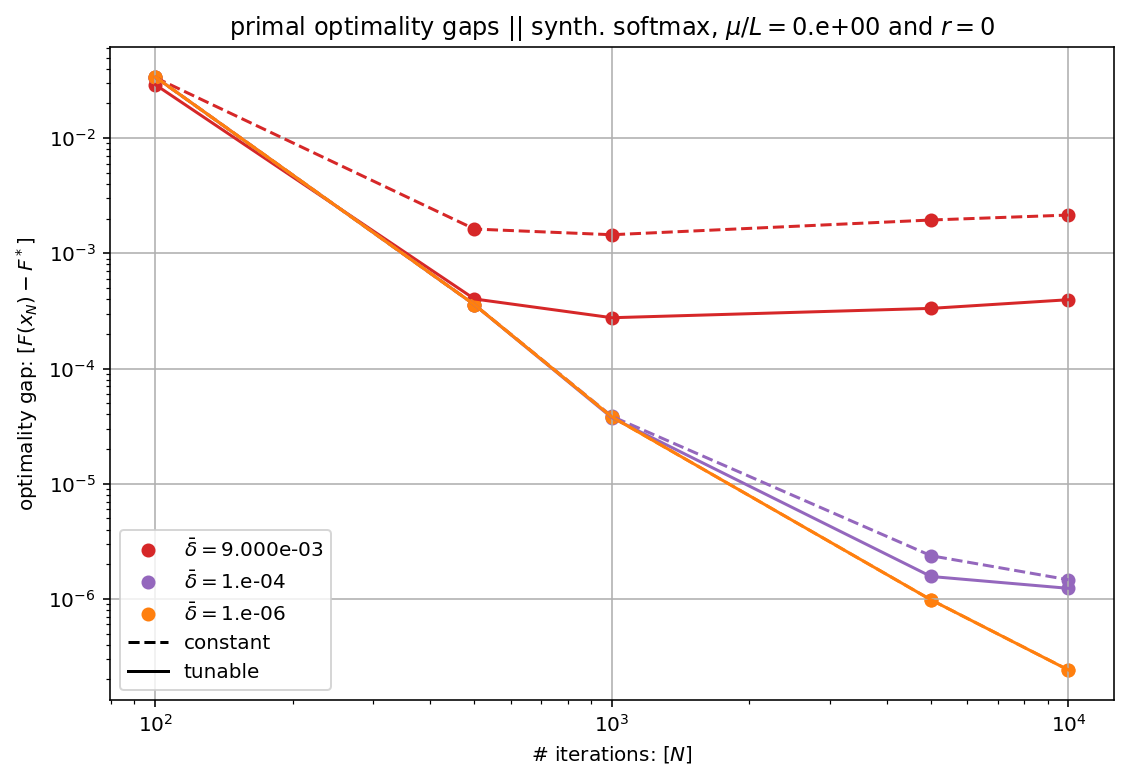

In [30]:
import seaborn as sns
#sns.set_theme(style="darkgrid")

plt.figure(figsize=(9,6))
plt.title('primal optimality gaps || synth. softmax, $\\mu / L = $'+condition_str+' and $r = $'+str(r_wish))

# Plot the responses for different events and regions
selected = df.groupby(['N_ref','bar_delta','r','schedule']).agg('mean')[['GAP']]

for col,delta_tested in zip(colors_delta[:len(balayage_delta)],balayage_delta):
    points_constant = []
    N_constant = []
    points_tunable = []
    N_tunable = []

    for N_tested in balayage_N:
        N_constant.append(N_tested)
        N_tunable.append(N_tested)
        points_tunable.append(selected.loc[(N_tested, delta_tested, r_wish, 'tunable')]['GAP'])
        points_constant.append(selected.loc[(N_tested, delta_tested, r_wish, 'constant')]['GAP'])
    
    plt.scatter(N_constant,points_constant,color=col,label='$\\bar{\\delta} = $'+np.format_float_scientific(delta_tested,3))
    plt.plot(N_constant,points_constant,color=col,linestyle='--')
    plt.scatter(N_tunable,points_tunable,color=col)
    plt.plot(N_tunable,points_tunable,color=col)
    
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# from data
# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()

# create manual symbols for legend
line_constant = Line2D([0], [0], label='constant', color='k',linestyle='--')
line_tunable = Line2D([0], [0], label='tunable', color='k',linestyle='-')


# add manual symbols to auto legend
handles.extend([line_constant, line_tunable])

plt.legend(handles=handles)
plt.xlabel('# iterations: [$N$]')
plt.ylabel('optimality gap: [$F(x_N)-F^*$]')
plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.savefig('replacement_r_0_paper_synthetic_reg.pdf',dpi=600)

In [24]:
selected

GAP
N_ref bar_delta r schedule              
100   0.000001  0 constant  3.390408e-02
                  tunable   3.390409e-02
      0.000100  0 constant  3.390200e-02
                  tunable   3.388911e-02
      0.009000  0 constant  3.351036e-02
                  tunable   2.909561e-02
500   0.000001  0 constant  3.579386e-04
                  tunable   3.579420e-04
      0.000100  0 constant  3.579833e-04
                  tunable   3.575468e-04
      0.009000  0 constant  1.624237e-03
                  tunable   4.016045e-04
1000  0.000001  0 constant  3.802489e-05
                  tunable   3.802247e-05
      0.000100  0 constant  3.843714e-05
                  tunable   3.740787e-05
      0.009000  0 constant  1.450087e-03
                  tunable   2.759886e-04
5000  0.000001  0 constant  9.812935e-07
                  tunable   9.812774e-07
      0.000100  0 constant  2.371072e-06
                  tunable   1.565879e-06
      0.009000  0 constant  1.946031e-03
                  tunable   3.327438e-04
10000 0.000001  0 constant  2.417475e-07
                  tunable   2.413038e-07
      0.000100  0 constant  1.466625e-06
                  tunable   1.235616e-06
      0.009000  0 constant  2.148438e-03
                  tunable   3.955223e-04